# Chapter 3 — Model Evaluation and Cross-Validation  
## Part I — Foundations of Machine Learning

Focuses on cross-validation, residual analysis, and performance metrics for model robustness in financial contexts.

## Linear Regression Toy 

Train | R²=0.847  MSE=0.135  MAE=0.285
  Val | R²=0.361  MSE=0.152  MAE=0.320
 Test | R²=0.175  MSE=0.133  MAE=0.291


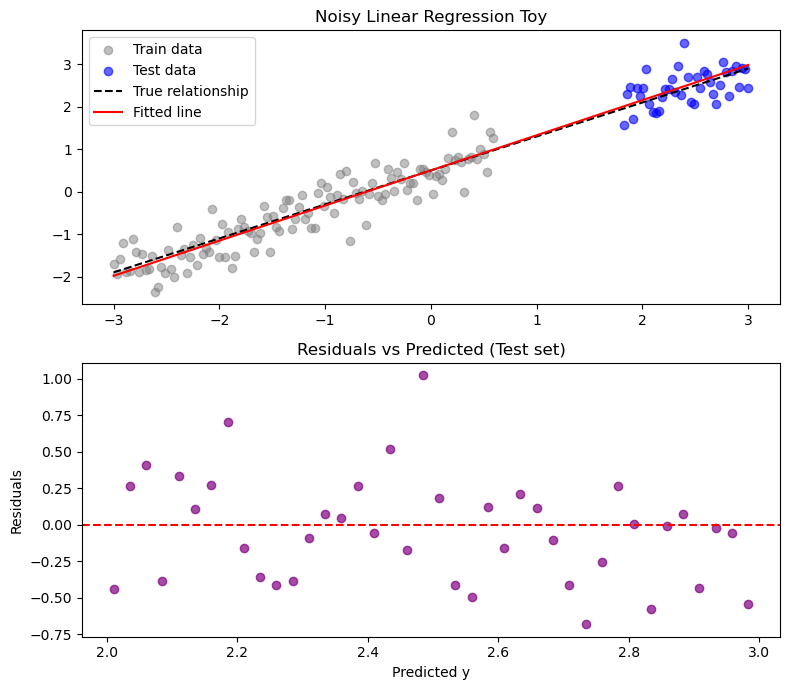

In [1]:
# ==============================================================
# Exercise 3.1 — Regression Toy Dataset (Fixed Random Seed)
# ==============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Fixed random seed for reproducibility ---
np.random.seed(42)

# --- Generate noisy linear data ---
n = 200
X = np.linspace(-3, 3, n).reshape(-1, 1)
y_true = 0.8 * X.squeeze() + 0.5           # underlying signal
noise = np.random.normal(0, 0.4, size=n)   # Gaussian noise
y = y_true + noise                         # observed target

# --- Train/Validation/Test split (60/20/20, chronological) ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# --- Fit Linear Regression ---
model = LinearRegression().fit(X_train, y_train)

# --- Predictions ---
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

# --- Metric Reporter ---
def report_metrics(y_true, y_pred, label):
    print(f"{label:>5} | R²={r2_score(y_true, y_pred):.3f}  "
          f"MSE={mean_squared_error(y_true, y_pred):.3f}  "
          f"MAE={mean_absolute_error(y_true, y_pred):.3f}")

report_metrics(y_train, y_pred_train, "Train")
report_metrics(y_val,   y_pred_val,   "Val")
report_metrics(y_test,  y_pred_test,  "Test")

# --- Visualization: Fit & Residuals ---
fig, axes = plt.subplots(2, 1, figsize=(8, 7))

# Fit line
axes[0].scatter(X_train, y_train, color="gray", alpha=0.5, label="Train data")
axes[0].scatter(X_test,  y_test,  color="blue", alpha=0.6, label="Test data")
axes[0].plot(X, y_true, "k--", label="True relationship")
axes[0].plot(X, model.predict(X), "r", label="Fitted line")
axes[0].legend(); axes[0].set_title("Noisy Linear Regression Toy")

# Residuals
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, color="purple", alpha=0.7)
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_xlabel("Predicted y")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs Predicted (Test set)")

plt.tight_layout()
plt.show()

## Moons Classification with Pipelines

,Model,Test Accuracy
0,Logistic Regression,0.920
1,Linear SVM,0.915
2,RBF SVM,0.965


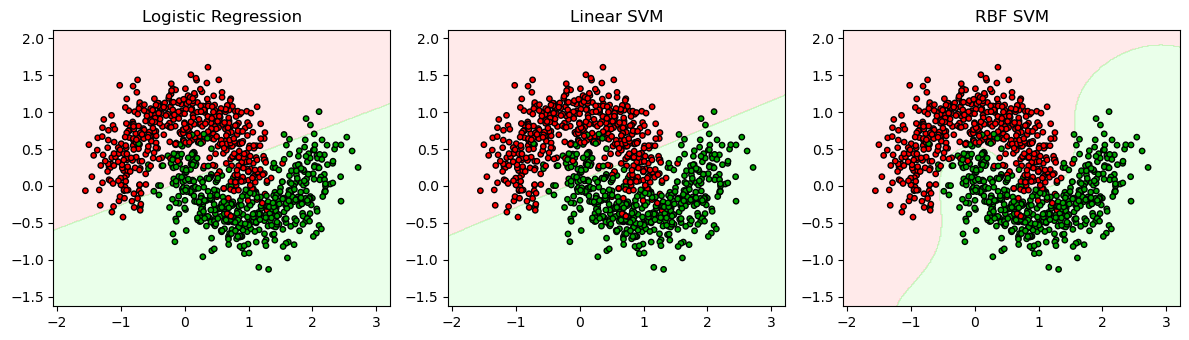

In [2]:
# ==============================================================
# Exercise 3.2 — Moons Classification (Pipeline Comparison)
# ==============================================================

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap


# --- Generate synthetic non-linear data ---
X, y = make_moons(n_samples=1000, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# --- Define pipelines ---
models = {
    "Logistic Regression": Pipeline([
        ("sc", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000))
    ]),
    "Linear SVM": Pipeline([
        ("sc", StandardScaler()),
        ("clf", SVC(kernel="linear"))
    ]),
    "RBF SVM": Pipeline([
        ("sc", StandardScaler()),
        ("clf", SVC(kernel="rbf", gamma="scale"))
    ])
}

# --- Fit & evaluate each model ---
results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    acc = accuracy_score(y_test, pipe.predict(X_test))
    results.append((name, acc))

# --- Display results ---
df_results = pd.DataFrame(results, columns=["Model", "Test Accuracy"])
display(df_results)

# --- Visualization helper ---
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=ListedColormap(["#FFBBBB", "#BBFFBB"]), alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#00AA00"]),
                edgecolor="k", s=20)
    plt.title(title); plt.xlabel("x₁"); plt.ylabel("x₂")
    plt.show()

# --- Plot decision boundaries ---
plt.figure(figsize=(12, 3.5))
for i, (name, pipe) in enumerate(models.items(), start=1):
    plt.subplot(1, 3, i)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = pipe.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ListedColormap(["#FFBBBB", "#BBFFBB"]), alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#00AA00"]),
                edgecolor="k", s=15)
    plt.title(name)
plt.tight_layout()
plt.show()

## Trees and capacity

Shallow Tree → depth=3, leaves=6, train acc=0.912, test acc=0.906
Confusion Matrix:
 [[83 13]
 [ 4 80]] 

Deep Tree → depth=13, leaves=34, train acc=1.000, test acc=0.889
Confusion Matrix:
 [[84 12]
 [ 8 76]] 



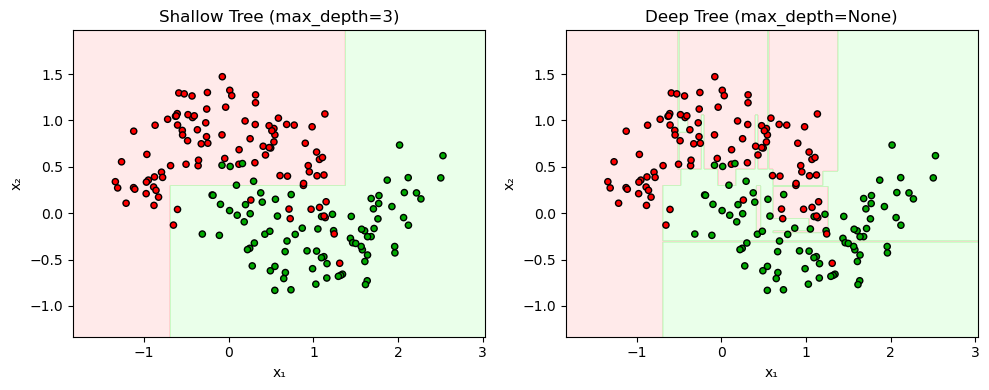

In [4]:
# ==============================================================
# Exercise 3.3 — Trees and Model Capacity (Shallow vs Deep)
# ==============================================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# --- Generate data ---
X, y = make_moons(n_samples=600, noise=0.25, random_state=42)

# --- Chronological split (train/test 70/30) ---
n = len(X)
n_train = int(0.7 * n)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

# --- Train shallow vs deep decision trees ---
tree_shallow = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_deep    = DecisionTreeClassifier(max_depth=None, random_state=42)

tree_shallow.fit(X_train, y_train)
tree_deep.fit(X_train, y_train)

# --- Evaluate ---
for name, model in [("Shallow", tree_shallow), ("Deep", tree_deep)]:
    y_pred = model.predict(X_test)
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test  = accuracy_score(y_test, y_pred)
    depth = model.get_depth()
    leaves = model.get_n_leaves()
    print(f"{name} Tree → depth={depth}, leaves={leaves}, "
          f"train acc={acc_train:.3f}, test acc={acc_test:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

# --- Decision Boundary Visualization ---
def plot_tree_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ListedColormap(["#FFBBBB", "#BBFFBB"]), alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#00AA00"]),
                edgecolor="k", s=20)
    plt.title(title); plt.xlabel("x₁"); plt.ylabel("x₂")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_tree_boundary(tree_shallow, X_test, y_test, "Shallow Tree (max_depth=3)")
plt.subplot(1, 2, 2)
plot_tree_boundary(tree_deep, X_test, y_test, "Deep Tree (max_depth=None)")
plt.tight_layout()
plt.show()

## Polynomial features 

Degree | R² (Val) | R² (Test)
     1 |   0.268 |   0.469
     2 |  -1.660 |  -7.070
     3 |   0.028 |   0.164


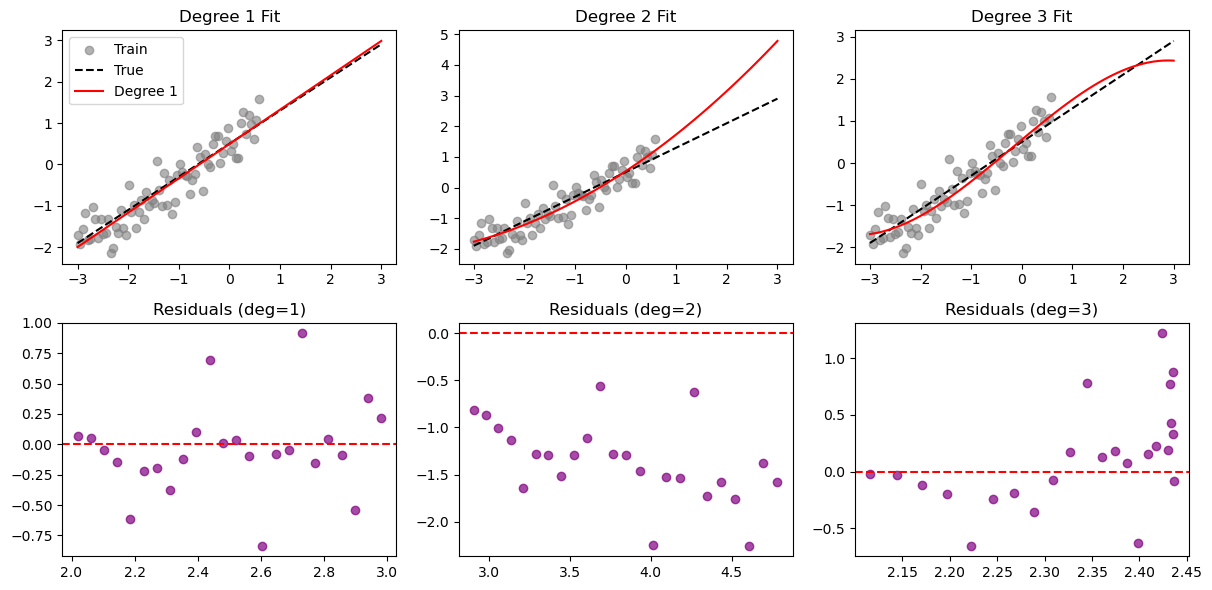

In [5]:
# ==============================================================
# Exercise 3.4 — Polynomial Features and Bias–Variance Tradeoff
# ==============================================================
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# --- Reuse the same noisy linear relationship ---
np.random.seed(42)
n = 120
X = np.linspace(-3, 3, n).reshape(-1, 1)
y_true = 0.8 * X.squeeze() + 0.5
noise = np.random.normal(0, 0.4, n)
y = y_true + noise

# --- Chronological split (60/20/20) ---
n_train, n_val = int(0.6*n), int(0.2*n)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

# --- Helper function to train and evaluate polynomial regression ---
def fit_poly(degree):
    pipe = Pipeline([
        ("sc", StandardScaler()),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lr", LinearRegression())
    ])
    pipe.fit(X_train, y_train)
    y_pred_val = pipe.predict(X_val)
    y_pred_test = pipe.predict(X_test)
    return pipe, y_pred_val, y_pred_test

# --- Fit models with degrees 1, 2, and 3 ---
degrees = [1, 2, 3]
results = []

for deg in degrees:
    model, y_pred_val, y_pred_test = fit_poly(deg)
    r2_val = r2_score(y_val, y_pred_val)
    r2_test = r2_score(y_test, y_pred_test)
    results.append((deg, r2_val, r2_test))

# --- Display validation vs test R² ---
print("Degree | R² (Val) | R² (Test)")
for deg, r2v, r2t in results:
    print(f"{deg:>6} | {r2v:7.3f} | {r2t:7.3f}")

# --- Plot fits and residuals for degree 1, 2, 3 ---
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, deg in enumerate(degrees):
    model, _, _ = fit_poly(deg)
    y_pred = model.predict(X)
    
    # Top row: fits
    axes[0, i].scatter(X_train, y_train, color="gray", alpha=0.6, label="Train")
    axes[0, i].plot(X, y_true, "k--", label="True")
    axes[0, i].plot(X, y_pred, "r", label=f"Degree {deg}")
    axes[0, i].set_title(f"Degree {deg} Fit")
    if i == 0: axes[0, i].legend()
    
    # Bottom row: residuals (test)
    y_pred_test = model.predict(X_test)
    residuals = y_test - y_pred_test
    axes[1, i].scatter(y_pred_test, residuals, color="purple", alpha=0.7)
    axes[1, i].axhline(0, color="red", linestyle="--")
    axes[1, i].set_title(f"Residuals (deg={deg})")

plt.tight_layout()
plt.show()

### Challenge 1: Hyperparameter tuning  

Best RBF SVM Params: {'svm__C': 10, 'svm__gamma': 1}
Best CV Accuracy: 0.948


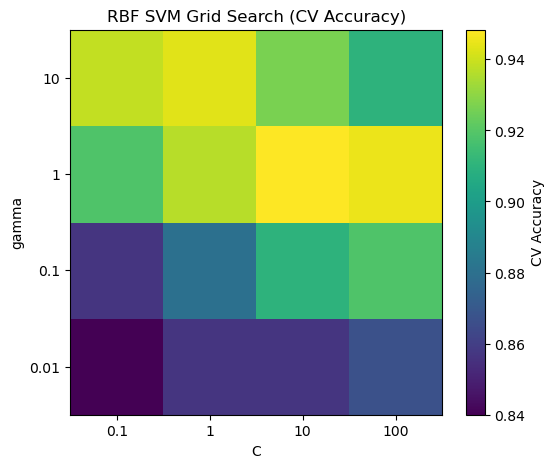

Best Tree Depth: 5
Best CV Accuracy: 0.932


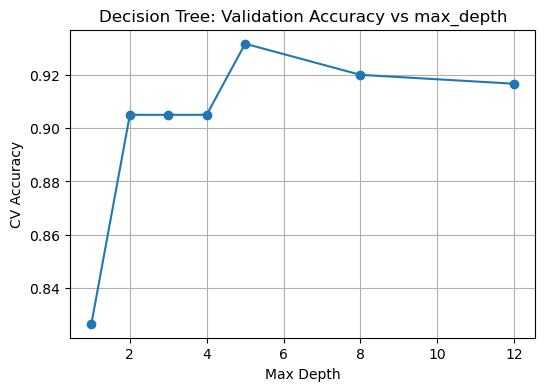

In [6]:
# ==============================================================
# Exercise 3.5 — Hyperparameter Tuning (GridSearchCV)
# ==============================================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# --- Generate nonlinear dataset (clean, controlled) ---
X, y = make_moons(n_samples=600, noise=0.25, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==============================================================
# RBF SVM: Tune C and gamma
# ==============================================================

pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])

param_grid_svm = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": [0.01, 0.1, 1, 10]
}

grid_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
).fit(X, y)

print("Best RBF SVM Params:", grid_svm.best_params_)
print(f"Best CV Accuracy: {grid_svm.best_score_:.3f}")

# --- Plot SVM validation heatmap ---
svm_results = pd.DataFrame(grid_svm.cv_results_)
pivot = svm_results.pivot(
    index="param_svm__gamma", columns="param_svm__C", values="mean_test_score"
)

plt.figure(figsize=(6,5))
plt.imshow(pivot, cmap="viridis", origin="lower", aspect="auto")
plt.colorbar(label="CV Accuracy")
plt.title("RBF SVM Grid Search (CV Accuracy)")
plt.xlabel("C"); plt.ylabel("gamma")
plt.xticks(range(len(param_grid_svm["svm__C"])), param_grid_svm["svm__C"])
plt.yticks(range(len(param_grid_svm["svm__gamma"])), param_grid_svm["svm__gamma"])
plt.show()

# ==============================================================
# Decision Tree: Tune max_depth
# ==============================================================

param_grid_tree = {"max_depth": [1, 2, 3, 4, 5, 8, 12, None]}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_tree,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
).fit(X, y)

print("Best Tree Depth:", grid_tree.best_params_["max_depth"])
print(f"Best CV Accuracy: {grid_tree.best_score_:.3f}")

# --- Plot validation curve for tree ---
tree_results = pd.DataFrame(grid_tree.cv_results_)
plt.figure(figsize=(6,4))
plt.plot(param_grid_tree["max_depth"], tree_results["mean_test_score"], marker="o")
plt.title("Decision Tree: Validation Accuracy vs max_depth")
plt.xlabel("Max Depth"); plt.ylabel("CV Accuracy")
plt.grid(True)
plt.show()

### Challenge 2: Class Imbalance

           Baseline
Accuracy      0.973
Precision     1.000
Recall        0.758
F1-score      0.862
ROC AUC       0.995


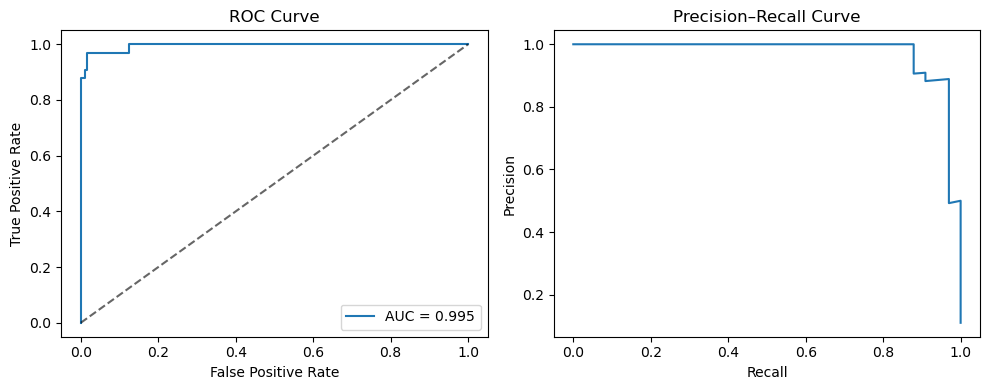

Balanced Logistic Regression → F1-score: 0.853


In [7]:
# ==============================================================
# Exercise 3.6 — Class Imbalance and Alternative Metrics
# ==============================================================

from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve
)

# --- Generate a strongly imbalanced dataset (90/10) ---
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.9, 0.1],
    flip_y=0.02,
    random_state=42
)

# --- Split & scale ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

# --- Fit baseline Logistic Regression ---
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# --- Compute metrics ---
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_prob)
}

print(pd.DataFrame(metrics, index=["Baseline"]).T.round(3))

# --- ROC and PR curves ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {metrics['ROC AUC']:.3f}")
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

# --- Refit with class weighting ---
clf_bal = LogisticRegression(class_weight='balanced')
clf_bal.fit(X_train, y_train)
y_pred_bal = clf_bal.predict(X_test)

f1_bal = f1_score(y_test, y_pred_bal)
print(f"Balanced Logistic Regression → F1-score: {f1_bal:.3f}")

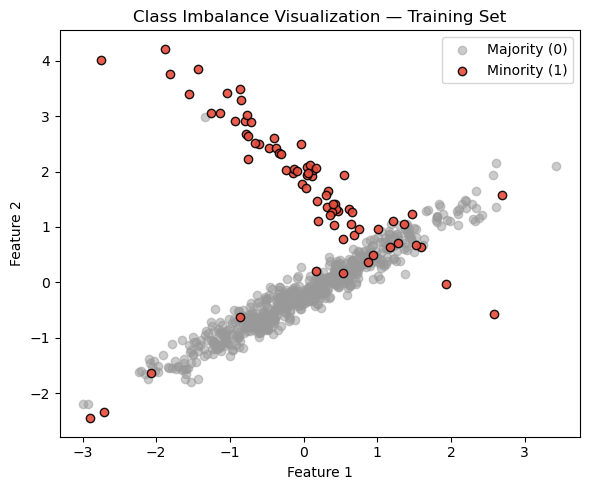

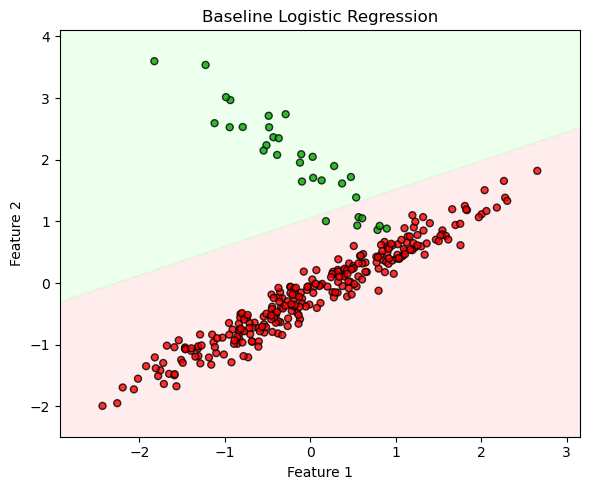

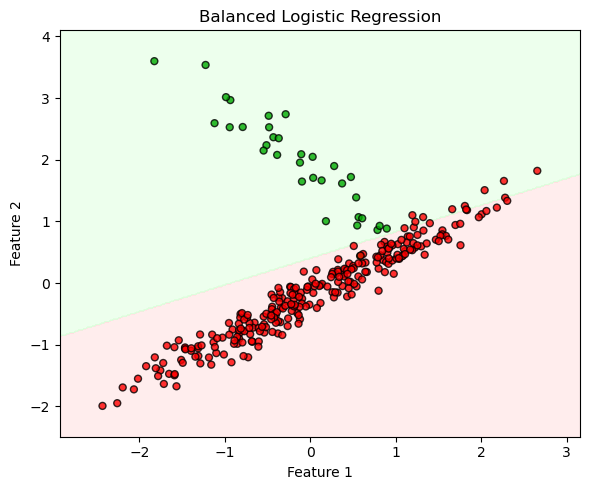

In [8]:
# ==============================================================
# Optional Visualization — Class Imbalance in Feature Space
# ==============================================================

# --- Base scatter showing imbalance ---
plt.figure(figsize=(6,5))
plt.scatter(
    X_train[y_train==0][:,0], X_train[y_train==0][:,1],
    alpha=0.5, label="Majority (0)", color="#999999"
)
plt.scatter(
    X_train[y_train==1][:,0], X_train[y_train==1][:,1],
    alpha=0.9, label="Minority (1)", color="#E74C3C", edgecolor="k"
)
plt.legend()
plt.title("Class Imbalance Visualization — Training Set")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.tight_layout()
plt.show()

# --- Decision boundary overlay for intuition ---
def plot_decision_boundary(model, X, y, title="Decision Boundary (Logistic Regression)"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(["#FFDDDD","#DDFFDD"]), alpha=0.5)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(["#FF0000","#00AA00"]),
                edgecolor="k", s=25, alpha=0.8)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()

# --- Plot boundary for both models ---
plot_decision_boundary(clf, X_test, y_test, title="Baseline Logistic Regression")
plot_decision_boundary(clf_bal, X_test, y_test, title="Balanced Logistic Regression")

### Challenge 3 – Probability Calibration

Uncalibrated SVM →  Brier: 0.088,  ROC AUC: 0.974
Calibrated SVM   →  Brier: 0.058,  ROC AUC: 0.975


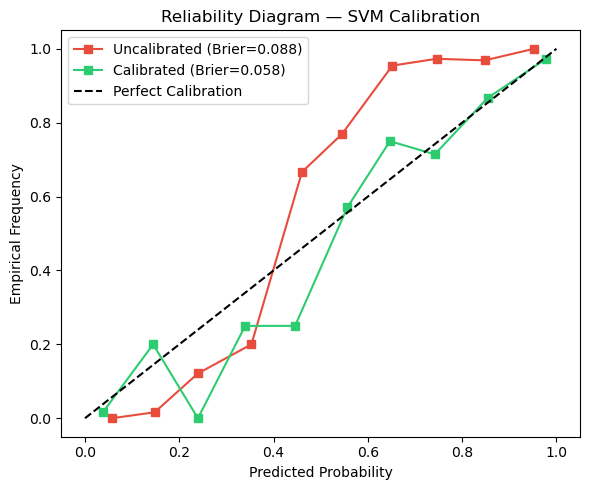

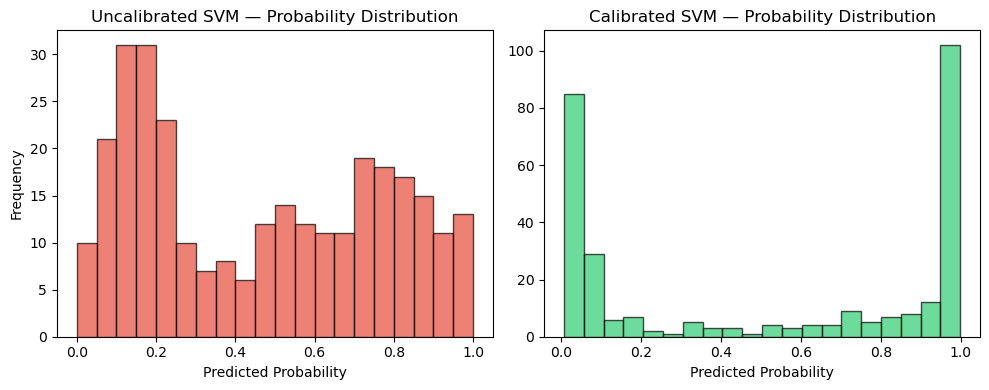

In [11]:
# ==============================================================
# Challenge 3 — Probability Calibration for SVM
# ==============================================================

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, accuracy_score, roc_auc_score

# --- Step 1. Synthetic dataset (well-balanced, moderately noisy) ---
X, y = make_classification(
    n_samples=1000, n_features=5, n_informative=3, n_redundant=0,
    class_sep=1.0, flip_y=0.03, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# --- Step 2. Base SVM (uncalibrated probabilities) ---
svm_raw = SVC(kernel="rbf", C=1.0, gamma="scale", probability=False, random_state=42)
svm_raw.fit(X_train, y_train)

# Decision function (raw uncalibrated scores)
scores_raw = svm_raw.decision_function(X_test)
probs_raw = (scores_raw - scores_raw.min()) / (scores_raw.max() - scores_raw.min())  # pseudo-prob proxy

# --- Step 3. Calibrated SVM (via Platt scaling / sigmoid) ---
cal_svm = CalibratedClassifierCV(
    estimator=SVC(kernel="rbf", C=1.0, gamma="scale"),
    method="sigmoid",
    cv=5
)
cal_svm.fit(X_train, y_train)
probs_cal = cal_svm.predict_proba(X_test)[:, 1]

# --- Step 4. Metrics comparison ---
brier_raw = brier_score_loss(y_test, probs_raw)
brier_cal = brier_score_loss(y_test, probs_cal)
roc_raw = roc_auc_score(y_test, probs_raw)
roc_cal = roc_auc_score(y_test, probs_cal)

print(f"Uncalibrated SVM →  Brier: {brier_raw:.3f},  ROC AUC: {roc_raw:.3f}")
print(f"Calibrated SVM   →  Brier: {brier_cal:.3f},  ROC AUC: {roc_cal:.3f}")

# --- Step 5. Reliability curves ---
prob_true_raw, prob_pred_raw = calibration_curve(y_test, probs_raw, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, probs_cal, n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred_raw, prob_true_raw, "s-", label=f"Uncalibrated (Brier={brier_raw:.3f})", color="#E74C3C")
plt.plot(prob_pred_cal, prob_true_cal, "s-", label=f"Calibrated (Brier={brier_cal:.3f})", color="#2ECC71")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Frequency")
plt.title("Reliability Diagram — SVM Calibration")
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 6. Probability distribution comparison ---
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(probs_raw, bins=20, color="#E74C3C", alpha=0.7, edgecolor="black")
plt.title("Uncalibrated SVM — Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(probs_cal, bins=20, color="#2ECC71", alpha=0.7, edgecolor="black")
plt.title("Calibrated SVM — Probability Distribution")
plt.xlabel("Predicted Probability")

plt.tight_layout()
plt.show()

### Extended Challenge 3 – Platt vs Isotonic Calibration

=== Calibration Performance Summary ===


,Model,Brier,ROC AUC
0,Uncalibrated,0.078,0.982
1,Sigmoid,0.043,0.983
2,Isotonic,0.044,0.982


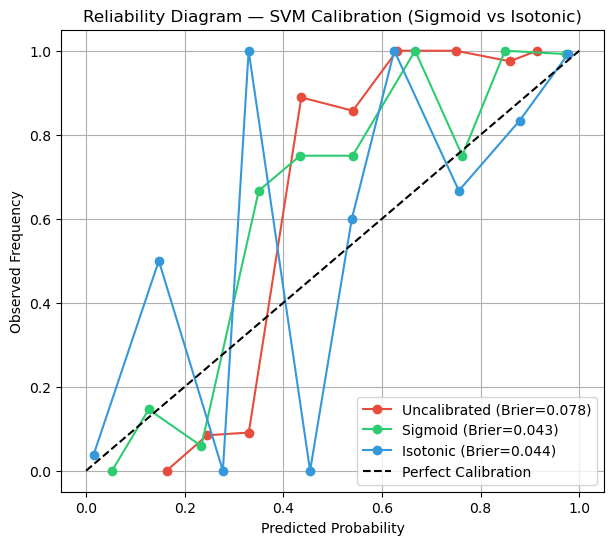

In [12]:
# ==============================================================
# Challenge 3b — Comparing Sigmoid vs Isotonic Calibration
# ==============================================================

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
from scipy.special import expit

# --- Step 1. Synthetic Data ---
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, flip_y=0.02, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Step 2. Base SVM (uncalibrated) ---
svm_base = SVC(kernel='rbf', C=1.0, gamma=0.5, probability=False, random_state=42)
svm_base.fit(X_train, y_train)
probs_uncal = expit(svm_base.decision_function(X_test))  # logistic transform for comparison

# --- Step 3. Calibrated Models ---
svm_sigmoid = CalibratedClassifierCV(SVC(kernel='rbf', C=1.0, gamma=0.5, probability=False, random_state=42),
                                     cv=5, method='sigmoid')
svm_sigmoid.fit(X_train, y_train)
probs_sigmoid = svm_sigmoid.predict_proba(X_test)[:, 1]

svm_isotonic = CalibratedClassifierCV(SVC(kernel='rbf', C=1.0, gamma=0.5, probability=False, random_state=42),
                                      cv=5, method='isotonic')
svm_isotonic.fit(X_train, y_train)
probs_isotonic = svm_isotonic.predict_proba(X_test)[:, 1]

# --- Step 4. Calibration Metrics ---
def summarize_model(name, probs):
    brier = brier_score_loss(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    return {"Model": name, "Brier": brier, "ROC AUC": auc}

summary = pd.DataFrame([
    summarize_model("Uncalibrated", probs_uncal),
    summarize_model("Sigmoid", probs_sigmoid),
    summarize_model("Isotonic", probs_isotonic)
])

print("=== Calibration Performance Summary ===")
display(summary.style.background_gradient(cmap="YlGnBu", axis=None).format({"Brier": "{:.3f}", "ROC AUC": "{:.3f}"}))

# --- Step 5. Reliability Curves ---
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test, probs_uncal, n_bins=10)
prob_true_sigmoid, prob_pred_sigmoid = calibration_curve(y_test, probs_sigmoid, n_bins=10)
prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_test, probs_isotonic, n_bins=10)

plt.figure(figsize=(7,6))
plt.plot(prob_pred_uncal, prob_true_uncal, "o-", label=f"Uncalibrated (Brier={summary.iloc[0]['Brier']:.3f})", color="#E74C3C")
plt.plot(prob_pred_sigmoid, prob_true_sigmoid, "o-", label=f"Sigmoid (Brier={summary.iloc[1]['Brier']:.3f})", color="#2ECC71")
plt.plot(prob_pred_isotonic, prob_true_isotonic, "o-", label=f"Isotonic (Brier={summary.iloc[2]['Brier']:.3f})", color="#3498DB")
plt.plot([0,1], [0,1], "k--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Reliability Diagram — SVM Calibration (Sigmoid vs Isotonic)")
plt.legend()
plt.grid(True)
plt.show()